Скопируем проект в локальную среду выполнения.


In [1]:
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project.git

Cloning into 'EEL6812_DeepFool_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93
Receiving objects: 100% (96/96), 33.99 MiB | 27.19 MiB/s, done.
Resolving deltas: 100% (27/27), done.


Сменим директорию исполнения на вновь созданную папку "EEL6812_DeepFool_Project" проекта.

In [2]:
%cd /content/EEL6812_DeepFool_Project

/content/EEL6812_DeepFool_Project


Выполним импорт стандартных и вспомогательных библиотек.

In [3]:
import numpy as np
import os
import json, torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack

Установим случайное рандомное значение в виде переменной rand_seed={11}
Установим указанное значение для np.random.seed и torch.manual_seed
В работе используем в качестсве устройства видеокарту (T4 GPU).

In [4]:
rand_seed = 11
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

Загрузим датасет MNIST c параметрами mnist_mean = 0.5, mnist_std = 0.5, mnist_dim = 28.


In [5]:
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

mnist_tf = transforms.Compose([ transforms.ToTensor(), transforms.Normalize( mean=mnist_mean, std=mnist_std)])

mnist_tf_train = transforms.Compose([ transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize( mean=mnist_mean, std=mnist_std)])

mnist_tf_inv = transforms.Compose([ transforms.Normalize( mean=0.0, std=np.divide(1.0, mnist_std)), transforms.Normalize( mean=np.multiply(-1.0, mnist_std), std=1.0)])

mnist_temp = datasets.MNIST(root='datasets/mnist', train=True, download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])
mnist_test = datasets.MNIST(root='datasets/mnist', train=False, download=True, transform=mnist_tf)

100%|██████████| 9912422/9912422 [00:00<00:00, 138165680.48it/s]

Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40676861.59it/s]


Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35914395.05it/s]


Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6157249.12it/s]


Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



Загрузим датасет CIFAR-10 c параметрами cifar_mean = [0.491, 0.482, 0.447] cifar_std = [0.202,
0.199, 0.201] cifar_dim = 32.


In [6]:
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)
cifar_tf = transforms.Compose([ transforms.ToTensor(), transforms.Normalize( mean=cifar_mean, std=cifar_std)])

cifar_tf_train = transforms.Compose([ transforms.RandomCrop( size=cifar_dim, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize( mean=cifar_mean, std=cifar_std)])

cifar_tf_inv = transforms.Compose([ transforms.Normalize( mean=[0.0, 0.0, 0.0], std=np.divide(1.0, cifar_std)), transforms.Normalize( mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])])

cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True, download=True, transform=cifar_tf_train)

cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])

cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False, download=True, transform=cifar_tf)

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:05<00:00, 30481281.74it/s]


Extracting datasets/cifar-10/cifar-10-python.tar.gz to datasets/cifar-10
Files already downloaded and verified


Выполним настройку и загрузку DataLoader с параметрамми batch_size = 64 workers = 4.

In [7]:
#DataLoader
batch_size = 64
workers = 4
mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Произведем обучение параметров.

In [8]:
train_model = True

epochs = 50
epochs_nin = 100

lr = 0.004
lr_nin = 0.01
lr_scale = 0.5

momentum = 0.9

print_step = 5

deep_batch_size = 10
deep_num_classes = 10
deep_overshoot = 0.02
deep_max_iters = 50

deep_args = [deep_batch_size, deep_num_classes, deep_overshoot, deep_max_iters]

if not os.path.isdir('weights/deepfool'): os.makedirs('weights/deepfool', exist_ok=True)

if not os.path.isdir('weights/fgsm'): os.makedirs('weights/fgsm', exist_ok=True)

Загрузим и оценим стойкость модели Network-In-Network Model к FGSM и DeepFool атакам на основе датасета CIFAR-10.

In [9]:
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=torch.device('cpu')))
evaluate_attack('cifar_nin_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_nin_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)
if device.type == 'cuda': torch.cuda.empty_cache()

FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms


Загрузим и оценим стойкость модели LeNet к FGSM и DeepFool атакам на основе датасета
CIFAR-10


In [10]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('cpu')))
evaluate_attack('cifar_lenet_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_lenet_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)
if device.type == 'cuda': torch.cuda.empty_cache()

FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


Выполним оценку атакующих примеров для сетей (LeNet).



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


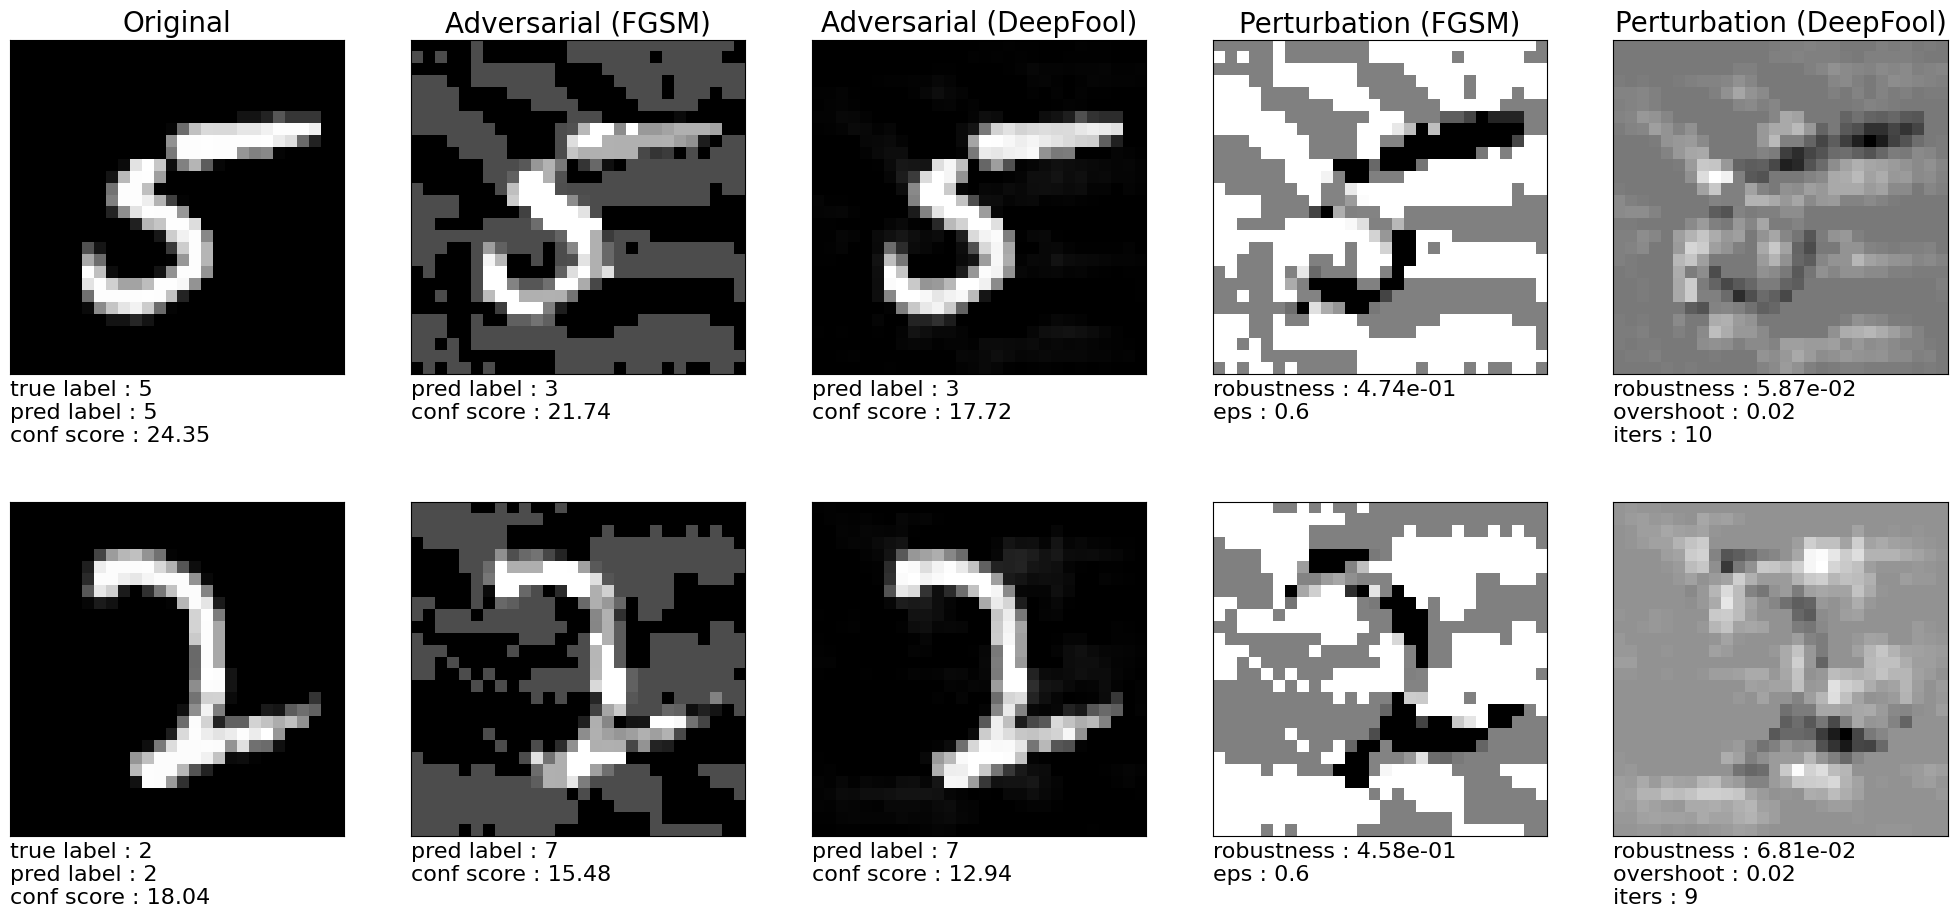

In [11]:
#LeNet
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
if device.type == 'cuda': torch.cuda.empty_cache()

Выполним оценку атакующих примеров для сетей (FCNet).

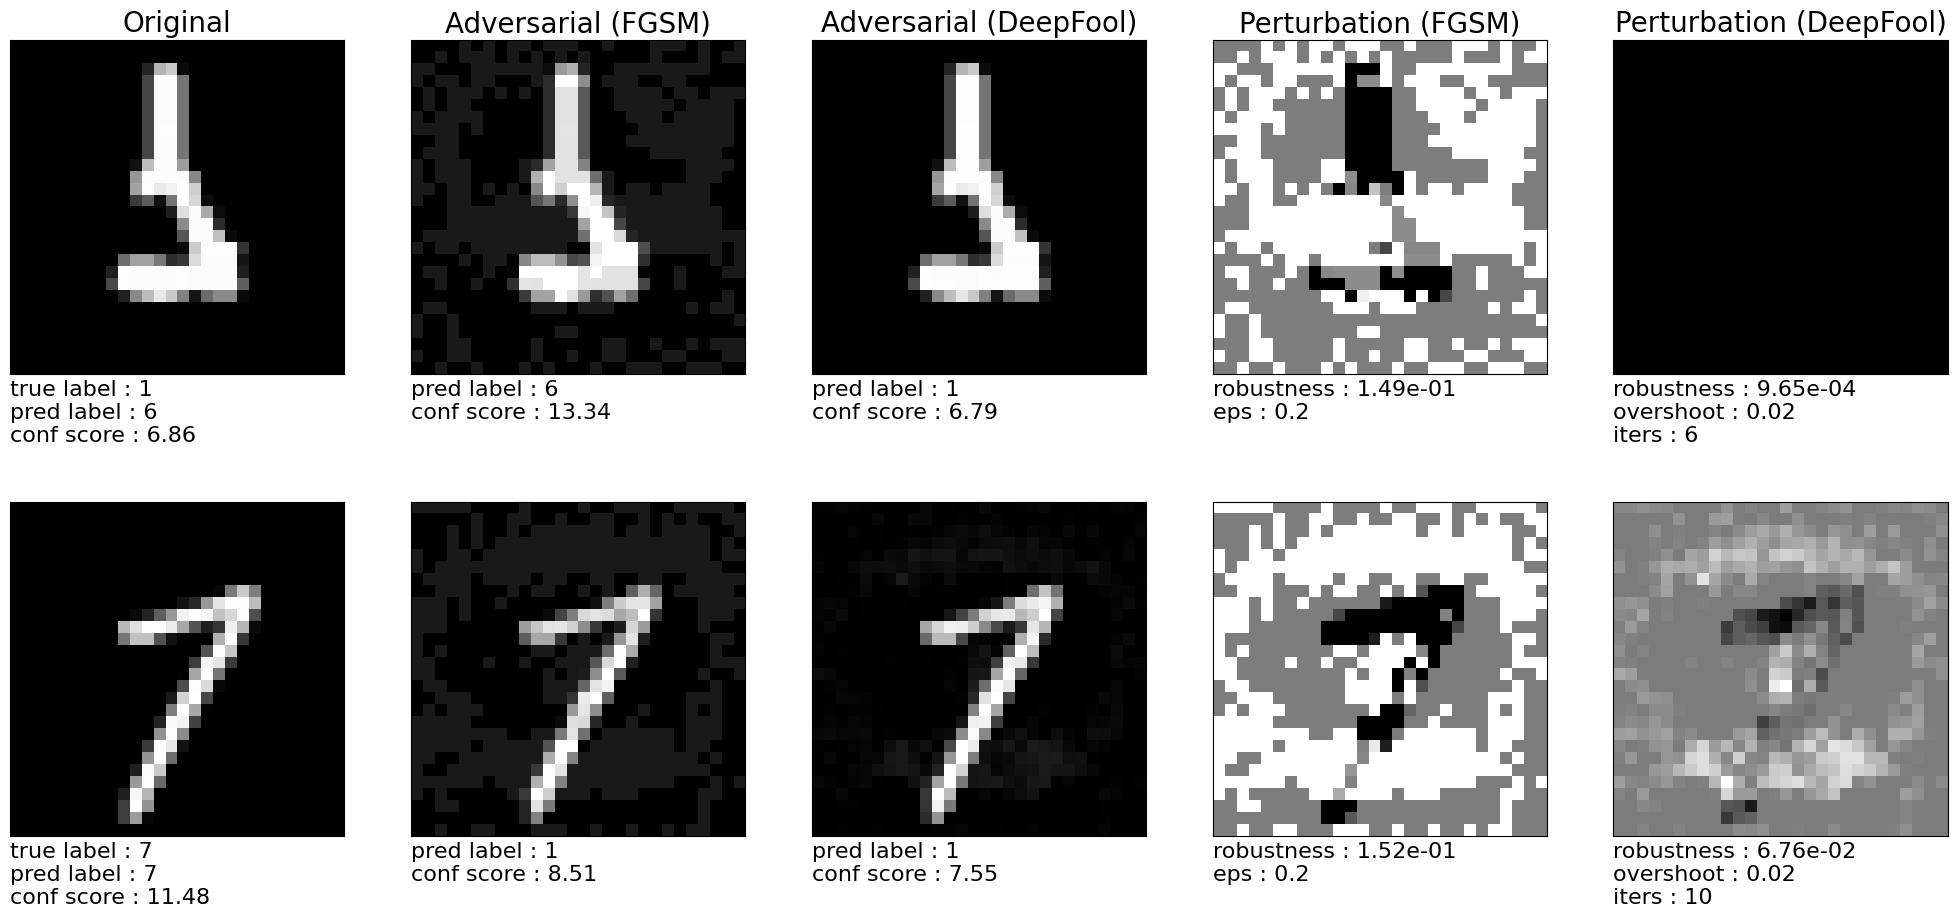

In [12]:
#FCNet
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
if device.type == 'cuda': torch.cuda.empty_cache()

Выполним оценку атакующих примеров для сетей (Network-in-Network).

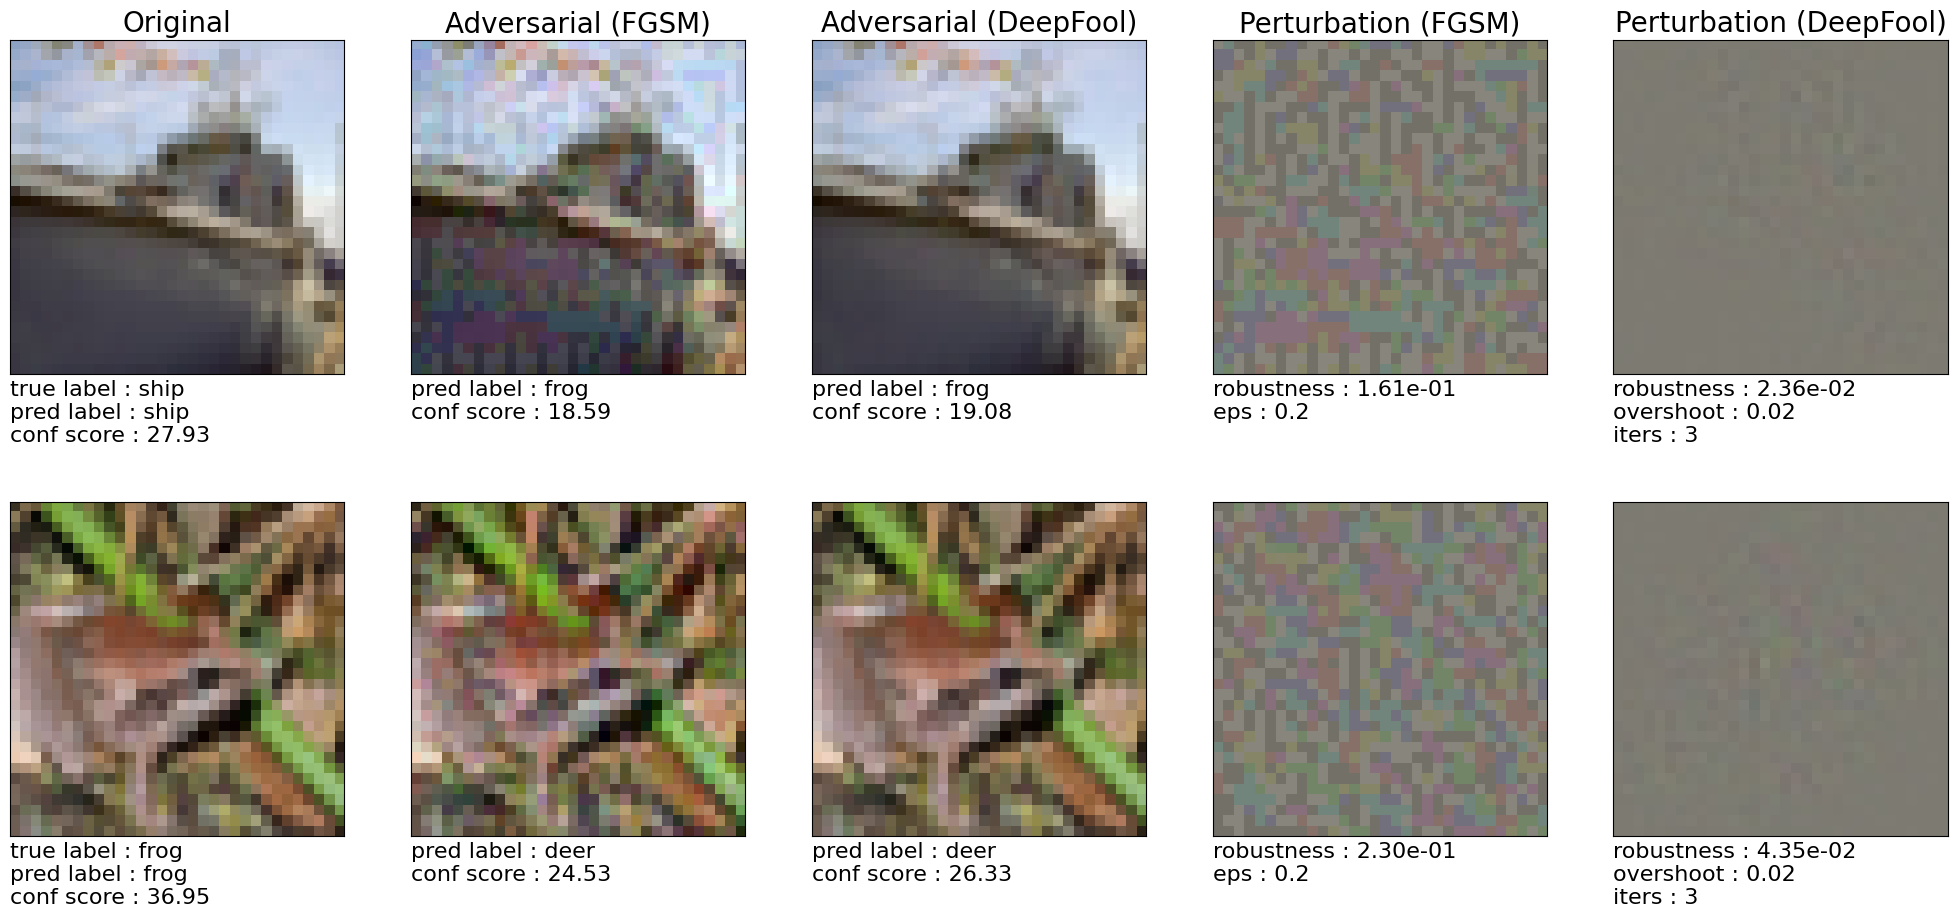

In [13]:
#Network-in-Network
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)
if device.type == 'cuda': torch.cuda.empty_cache()

Выполним оценку атакующих примеров для сетей (LeNet CIFAR-10).

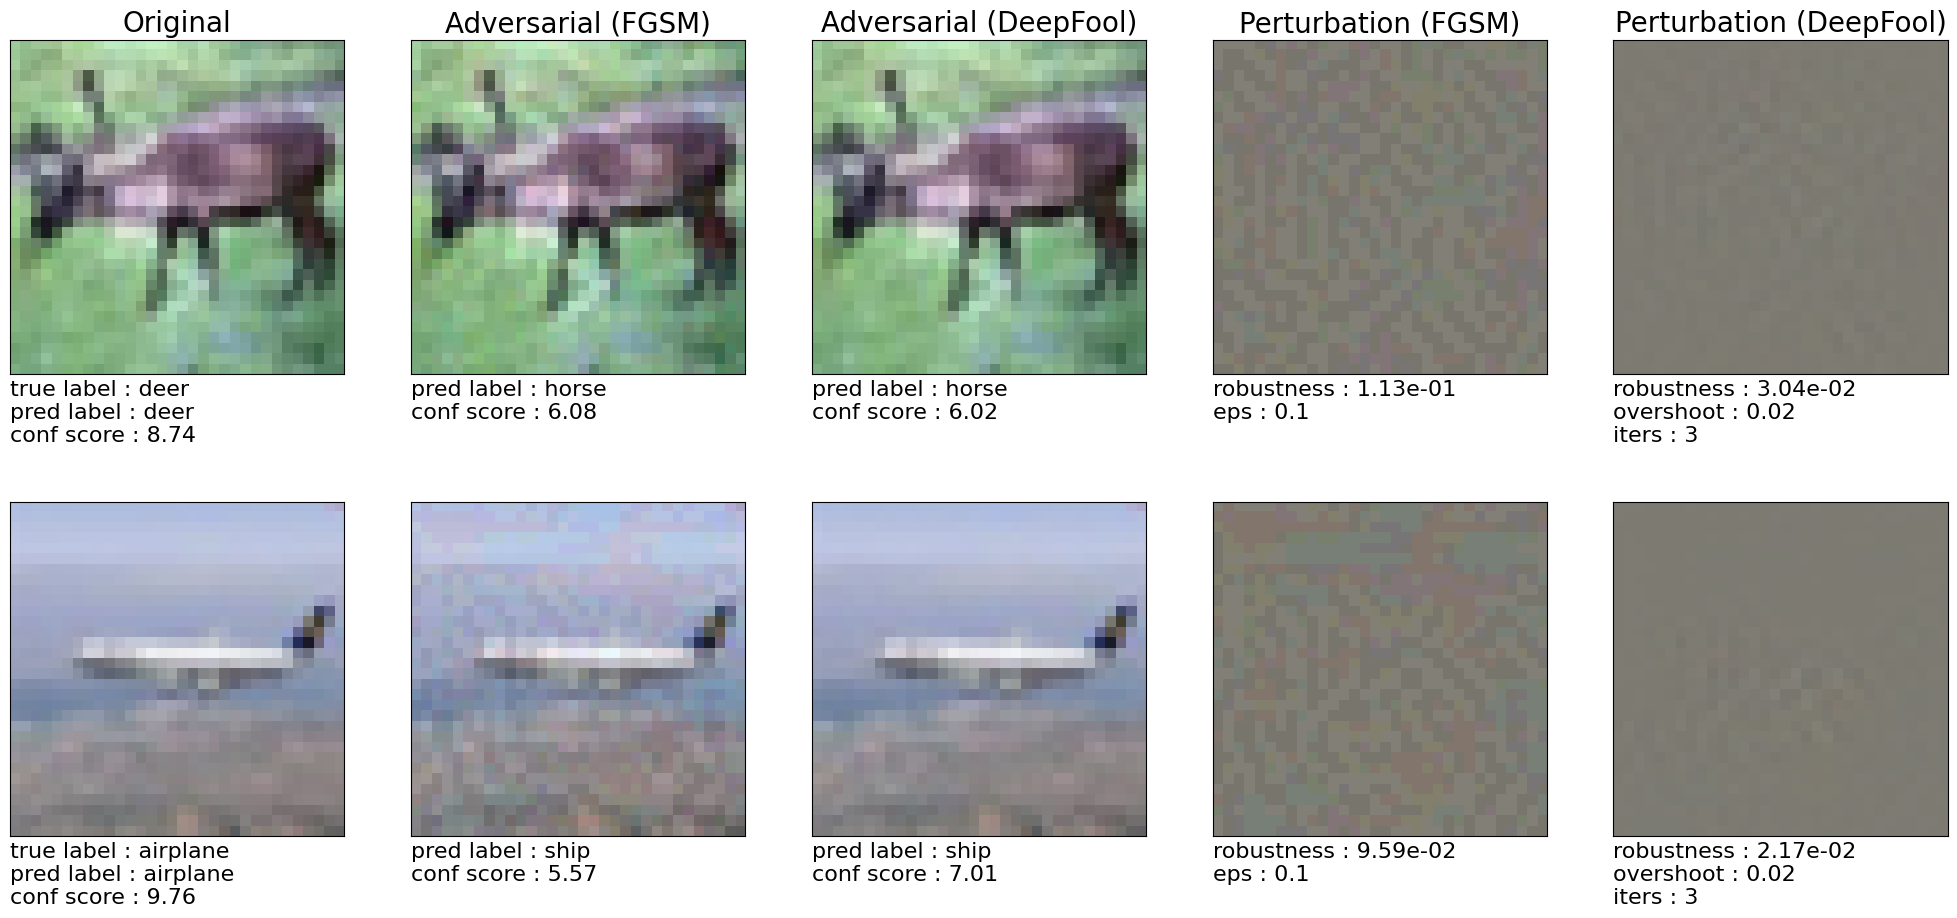

In [14]:
#LeNet CIFAR-10
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)
if device.type == 'cuda': torch.cuda.empty_cache()

Отражаем отличия для fgsm_eps=(0.001, 0.02, 0.5, 0.9, 10)

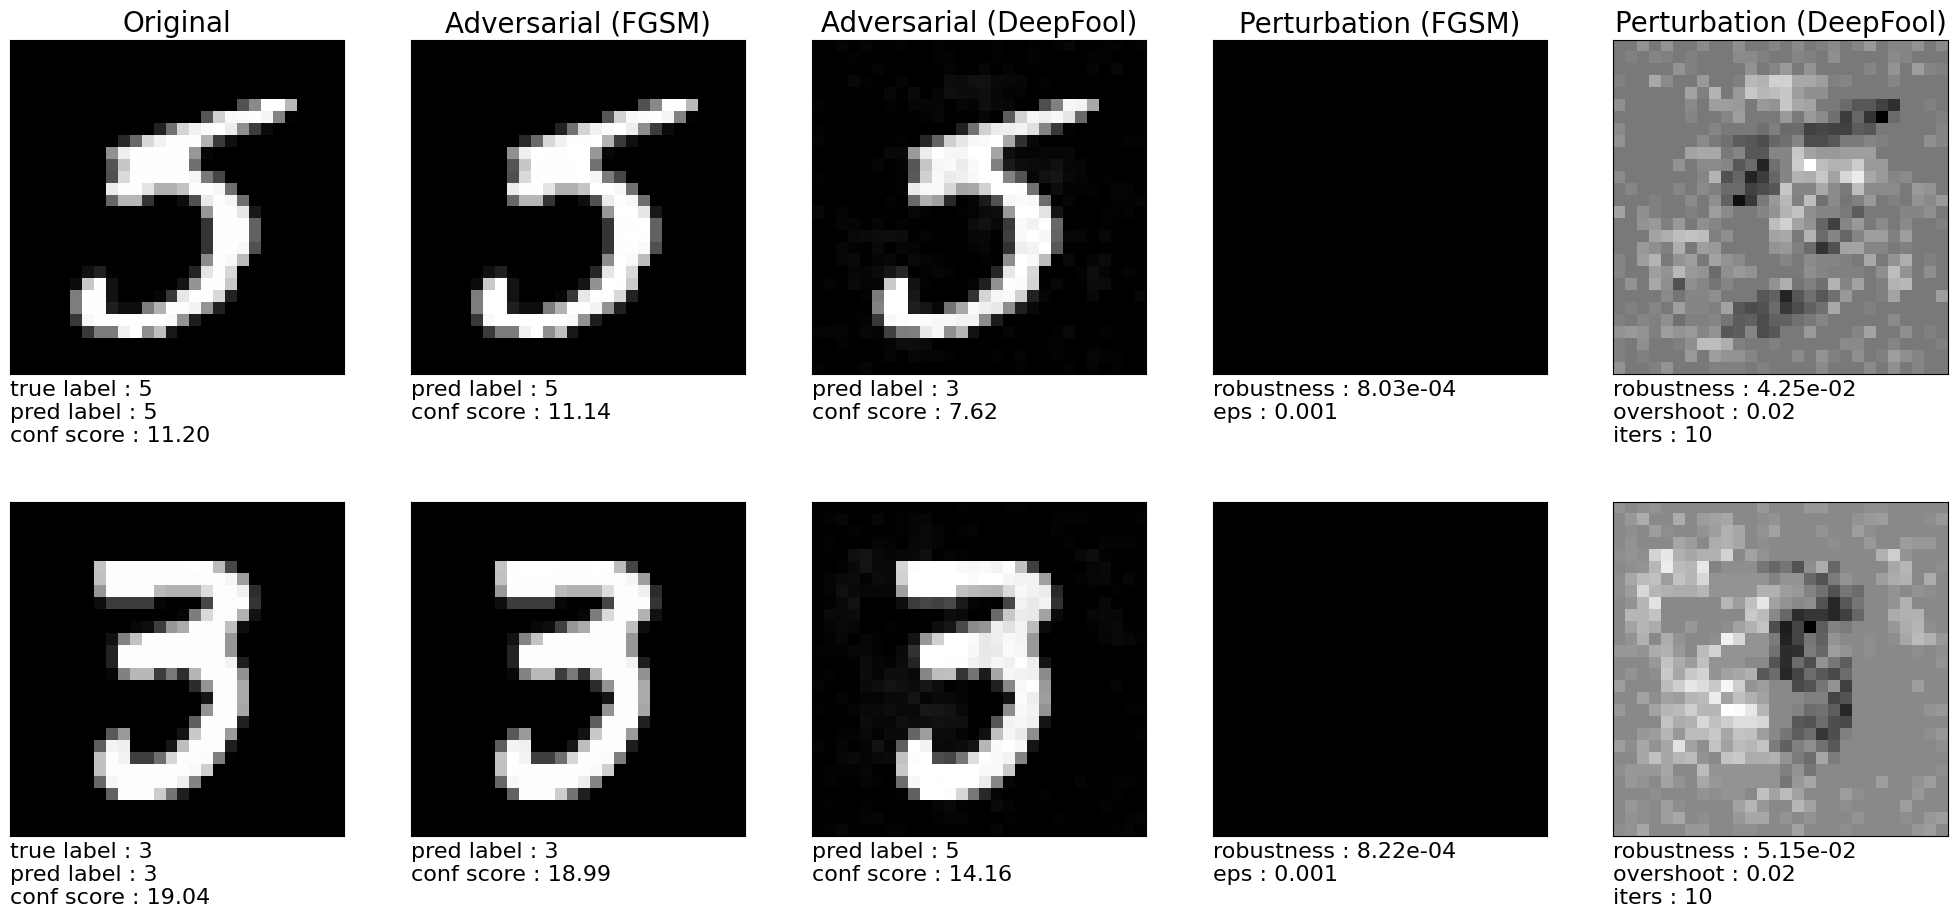

In [15]:
fgsm_eps = 0.001
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
if device.type == 'cuda': torch.cuda.empty_cache()

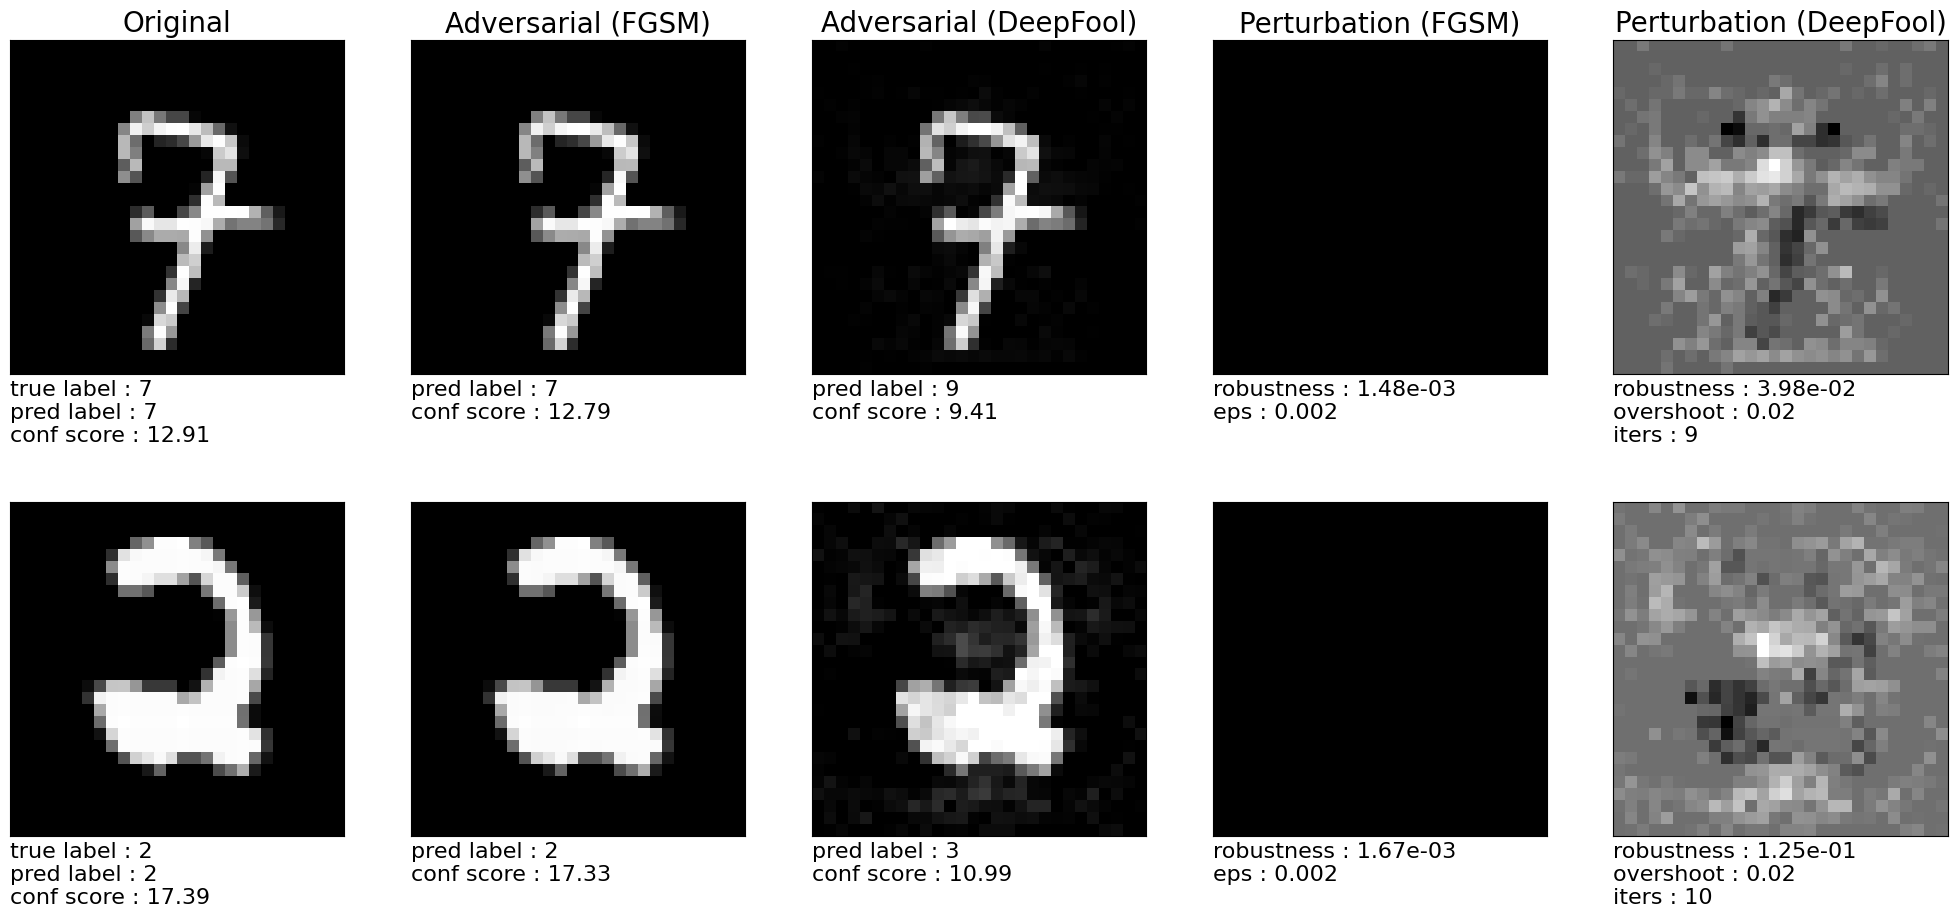

In [16]:
fgsm_eps = 0.002
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
if device.type == 'cuda': torch.cuda.empty_cache()

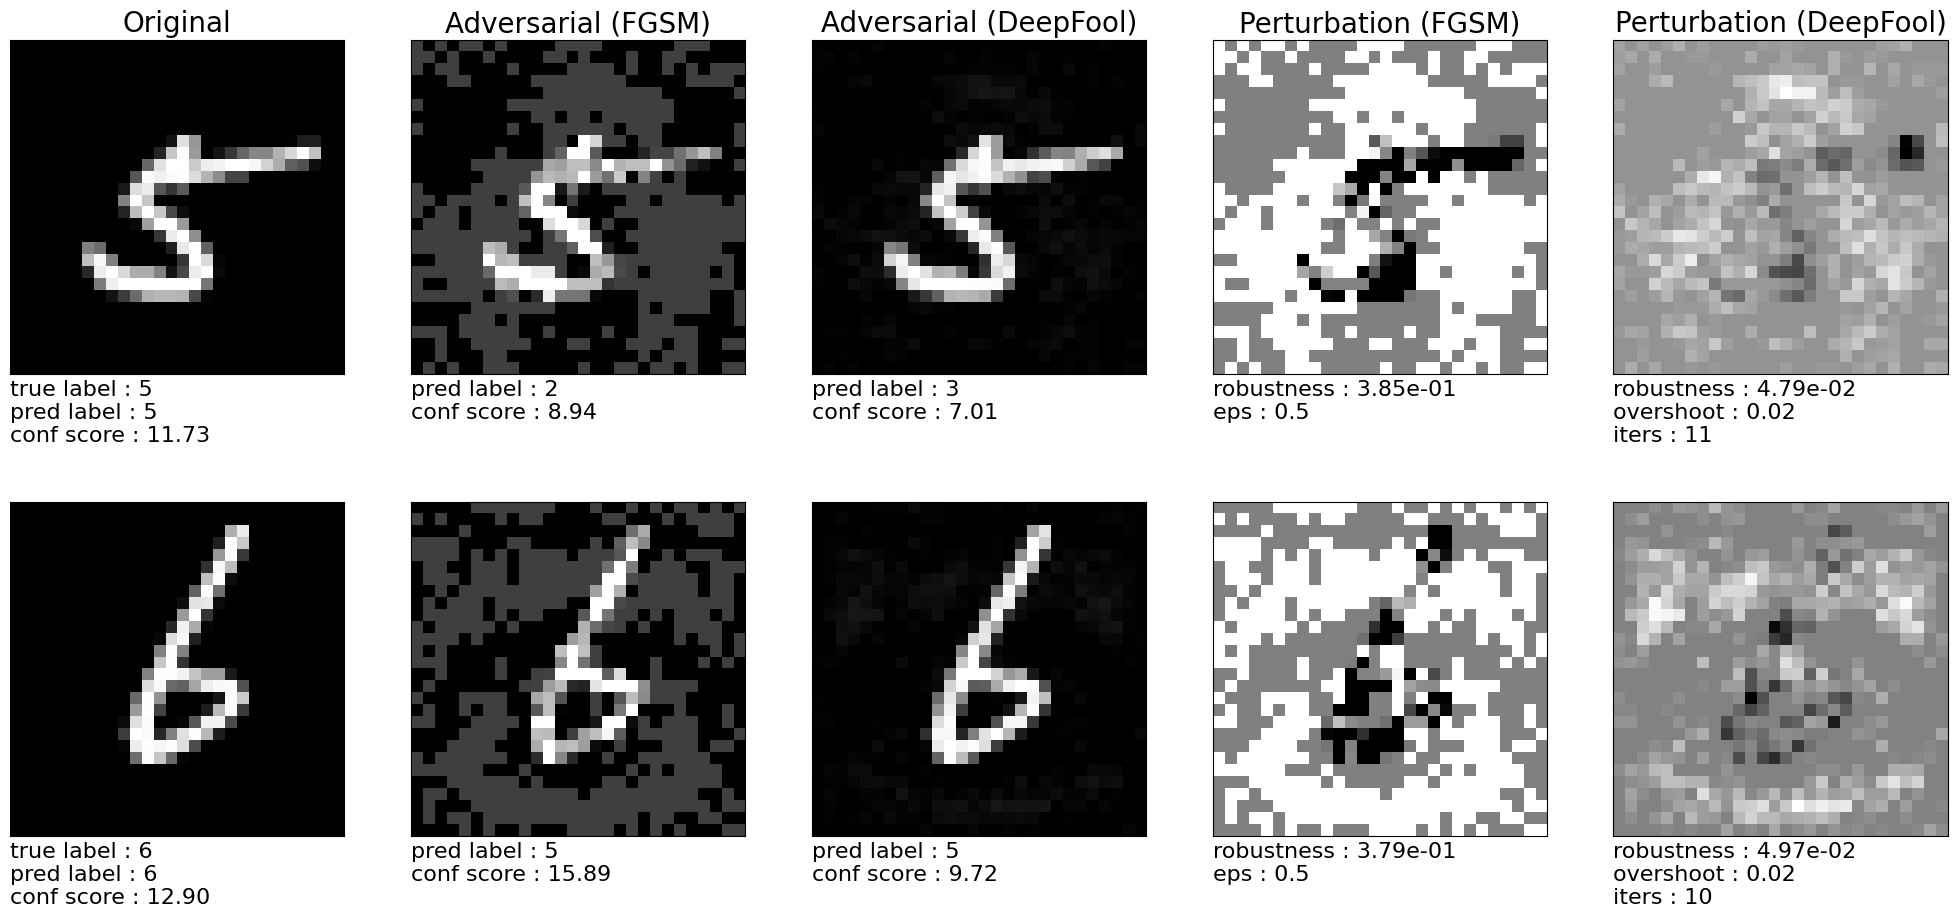

In [17]:
fgsm_eps = 0.5
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
if device.type == 'cuda': torch.cuda.empty_cache()

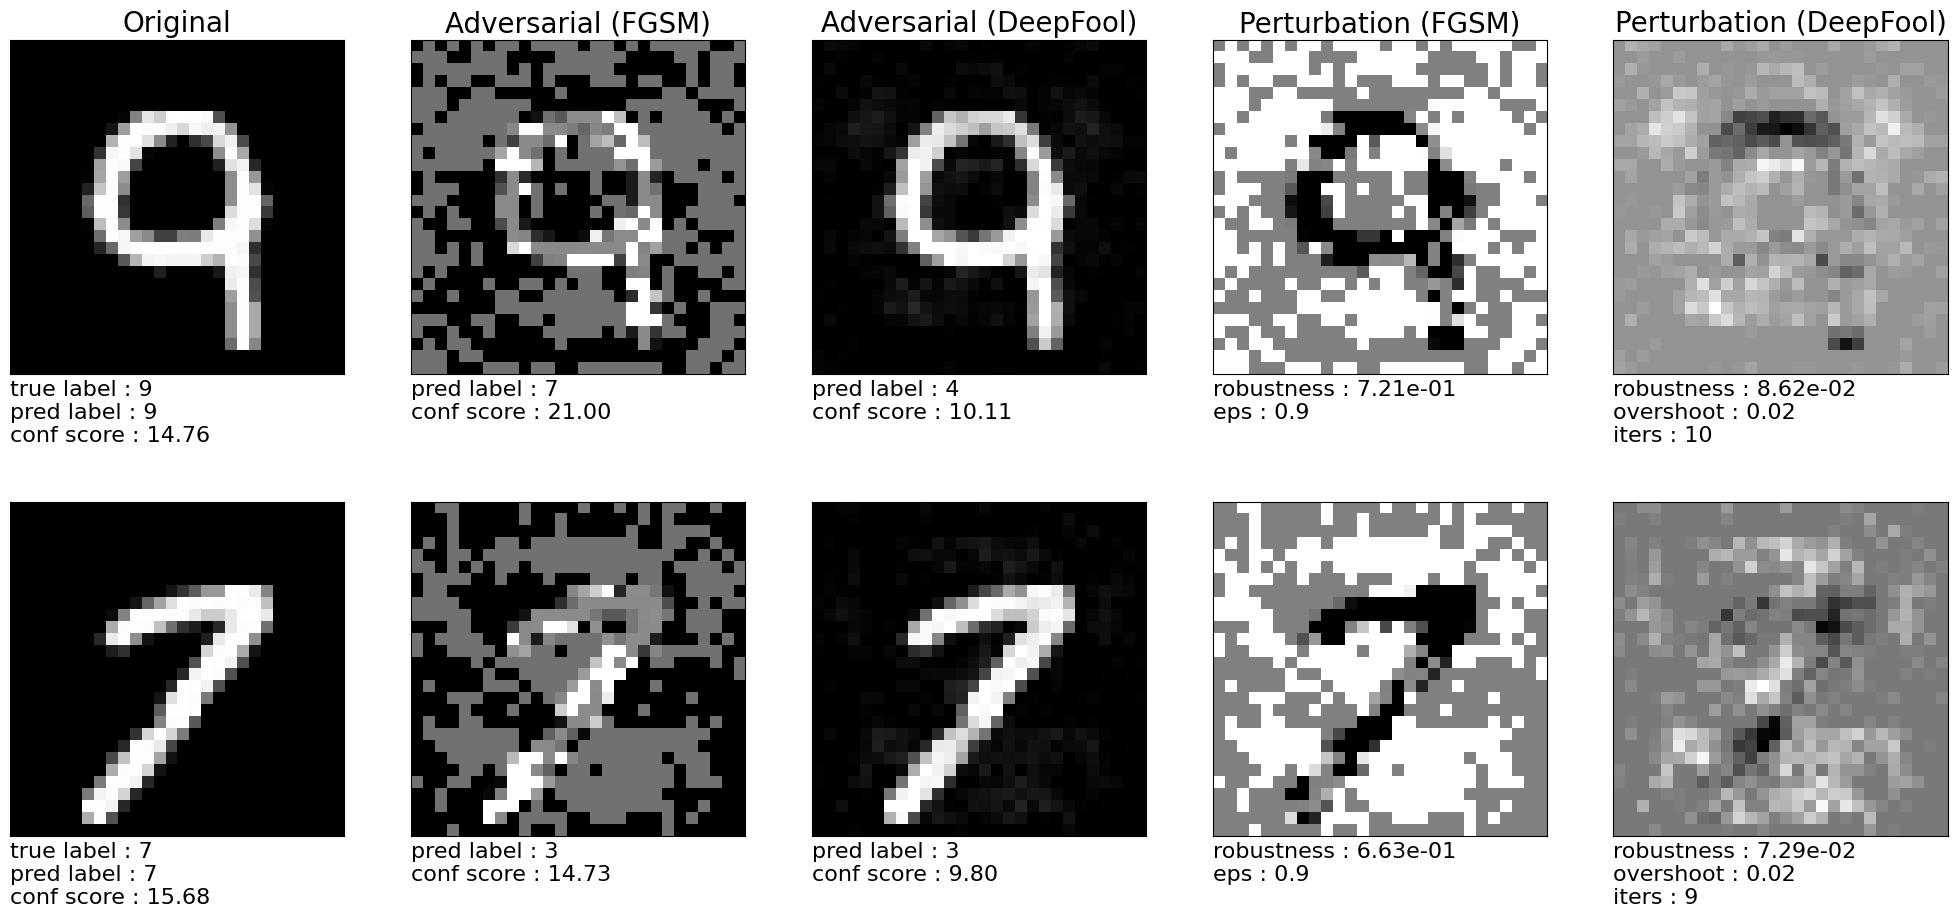

In [18]:
fgsm_eps = 0.9
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
if device.type == 'cuda': torch.cuda.empty_cache()

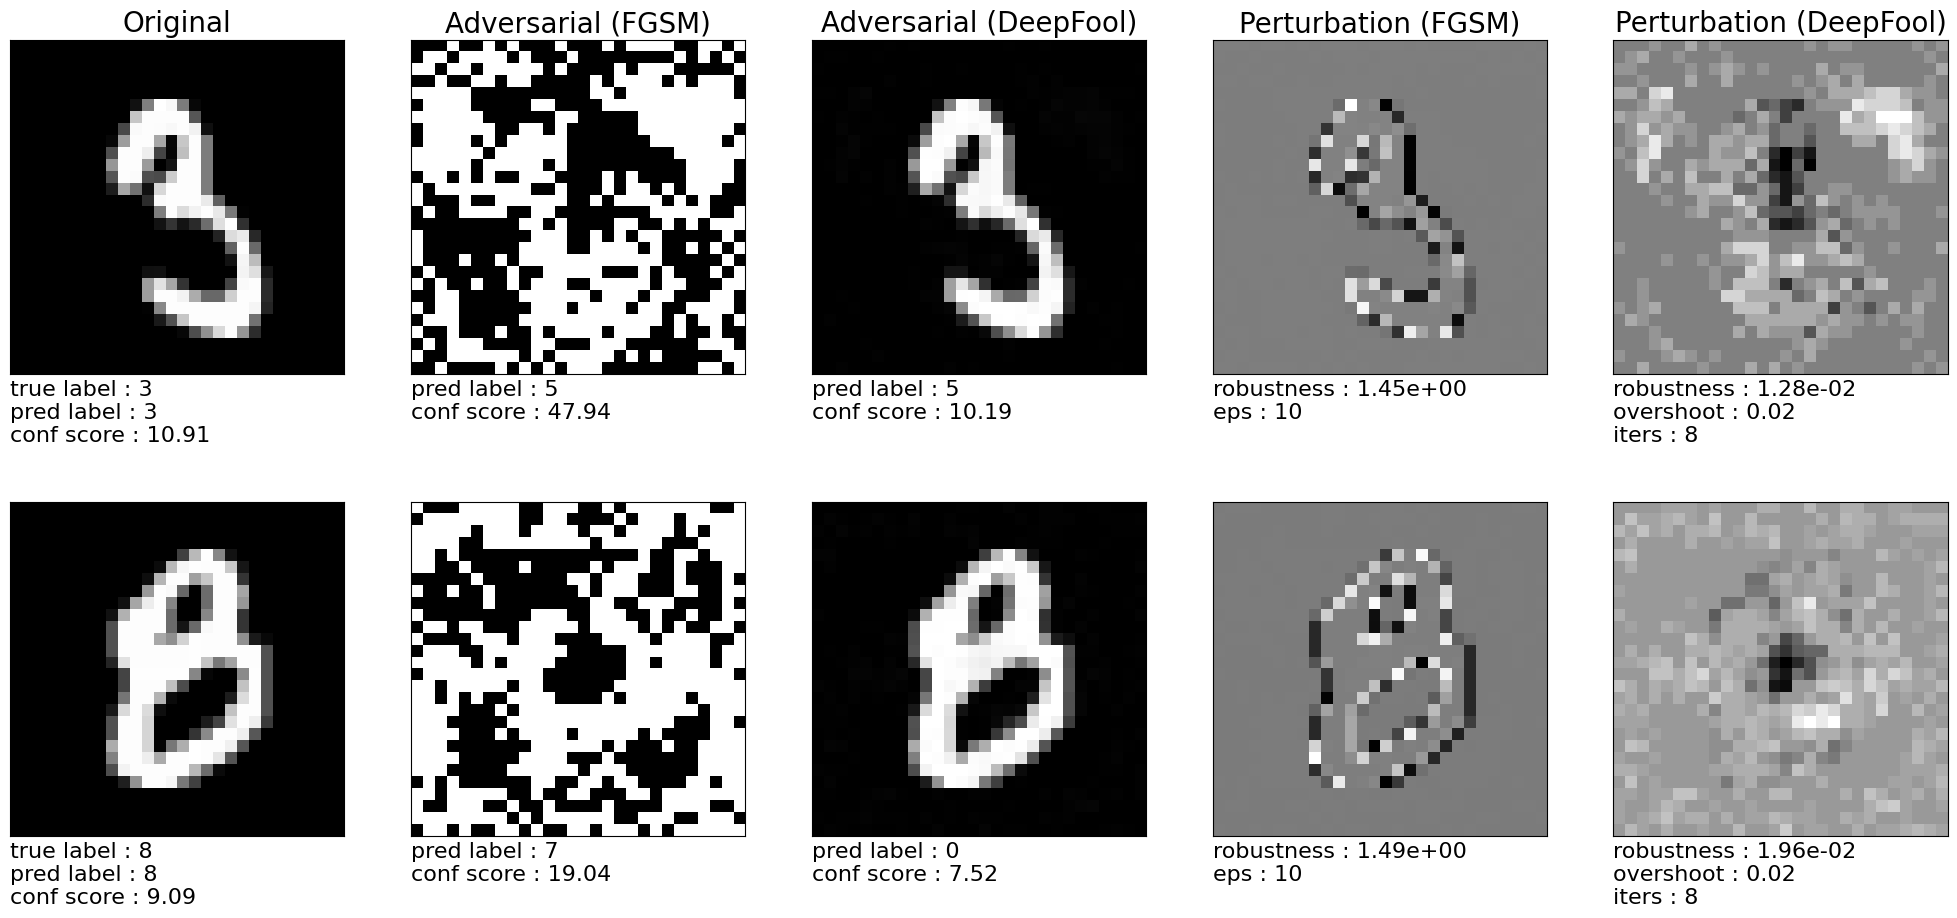

In [19]:
fgsm_eps = 10
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
if device.type == 'cuda': torch.cuda.empty_cache()

Выявим закономерность/обнаружим отсутсвие влияния параметра eps для сетей FC LeNet на
датасете MNIST, NiN LeNEt на датасете CIFAR.

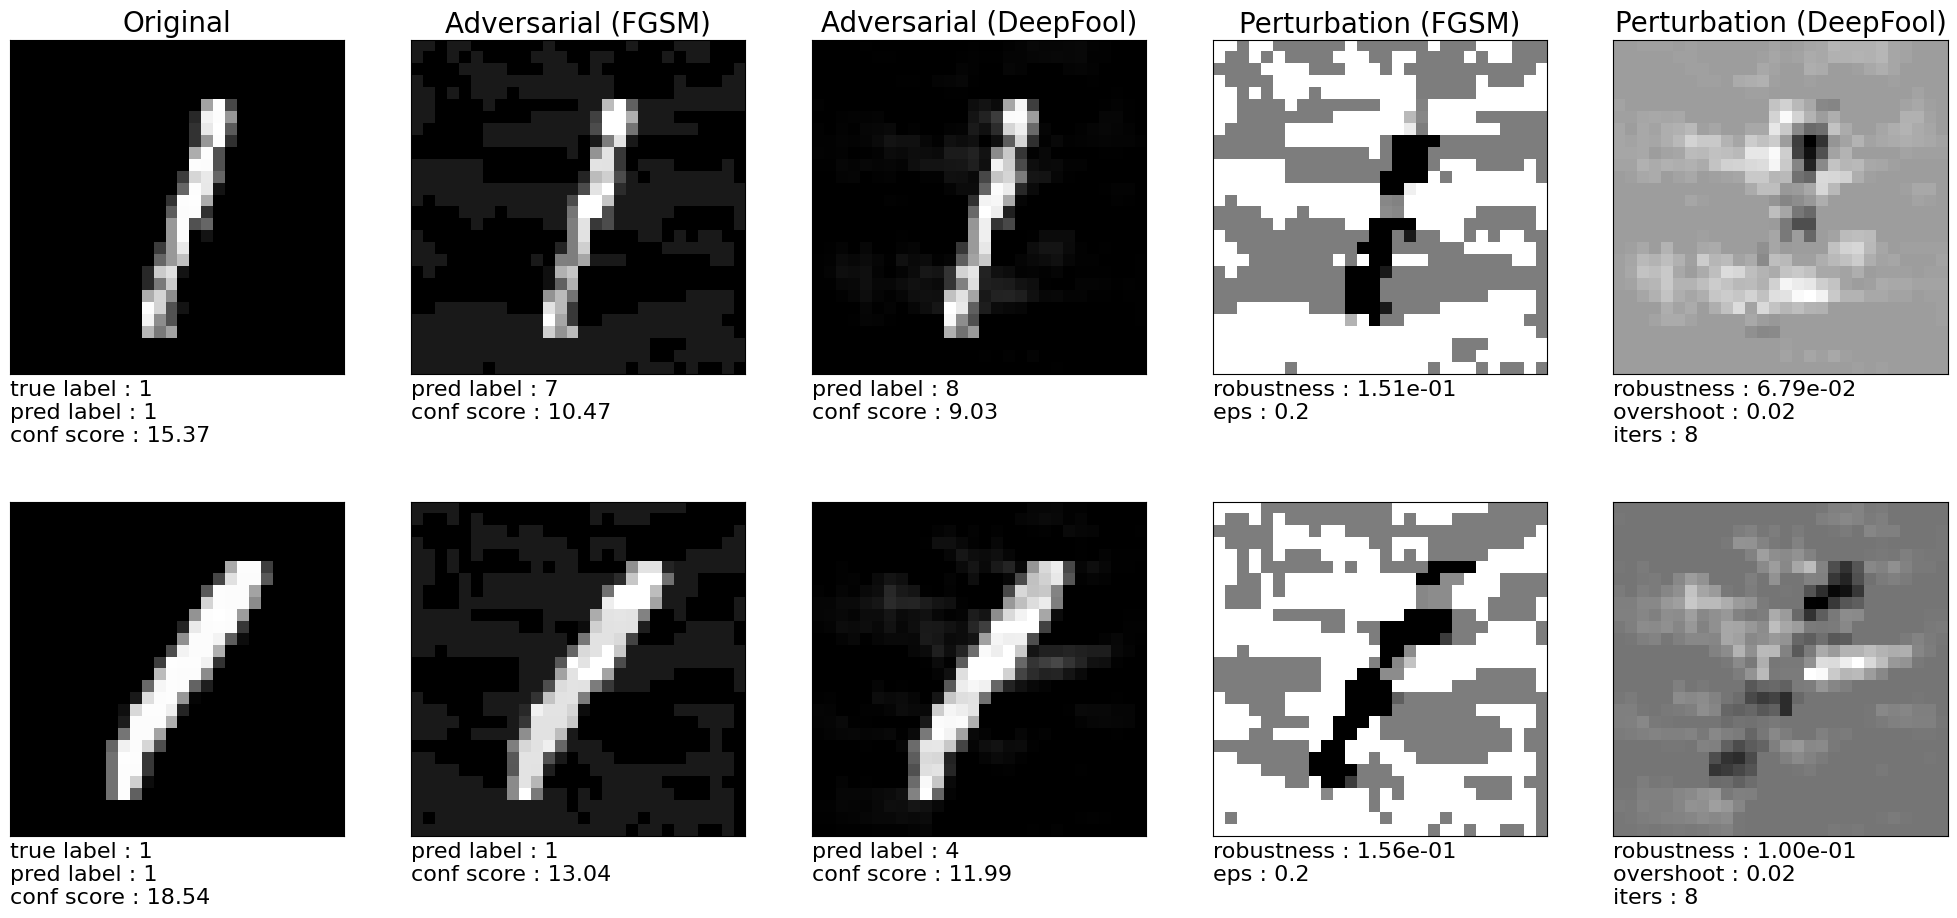

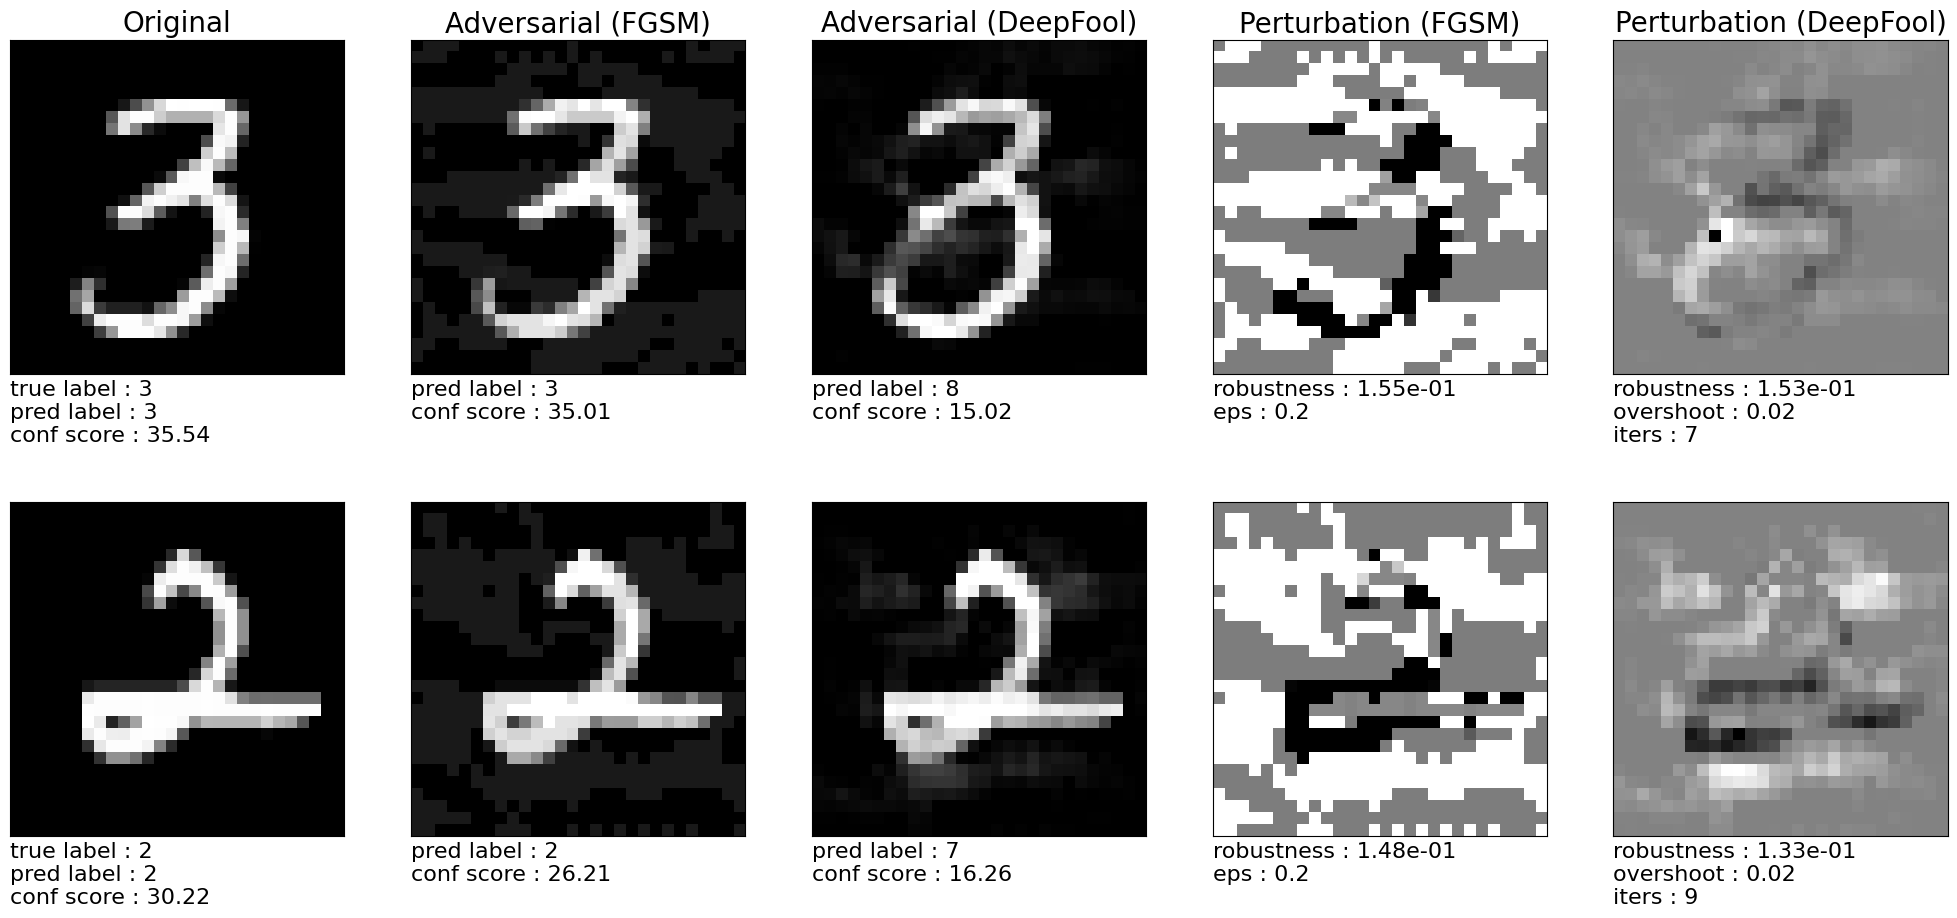

In [20]:
fgsm_eps = 0.2
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
if device.type == 'cuda': torch.cuda.empty_cache()
#fgsm_eps = 0.2
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
if device.type == 'cuda': torch.cuda.empty_cache()

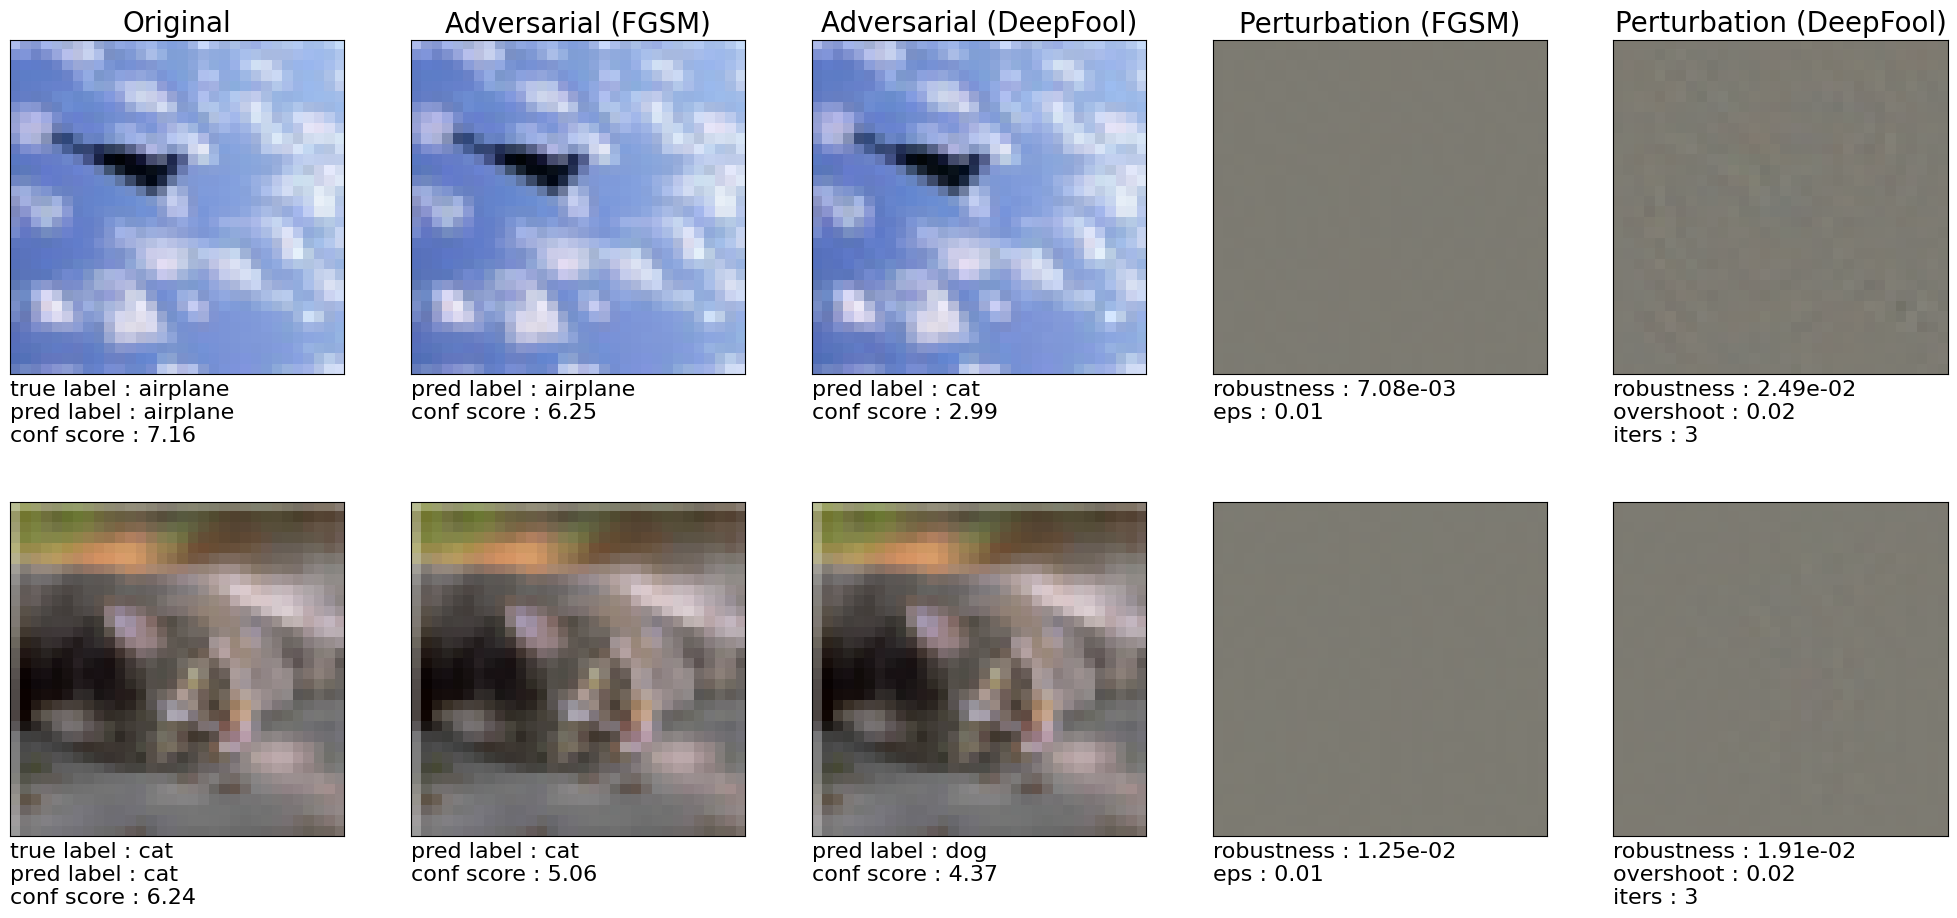

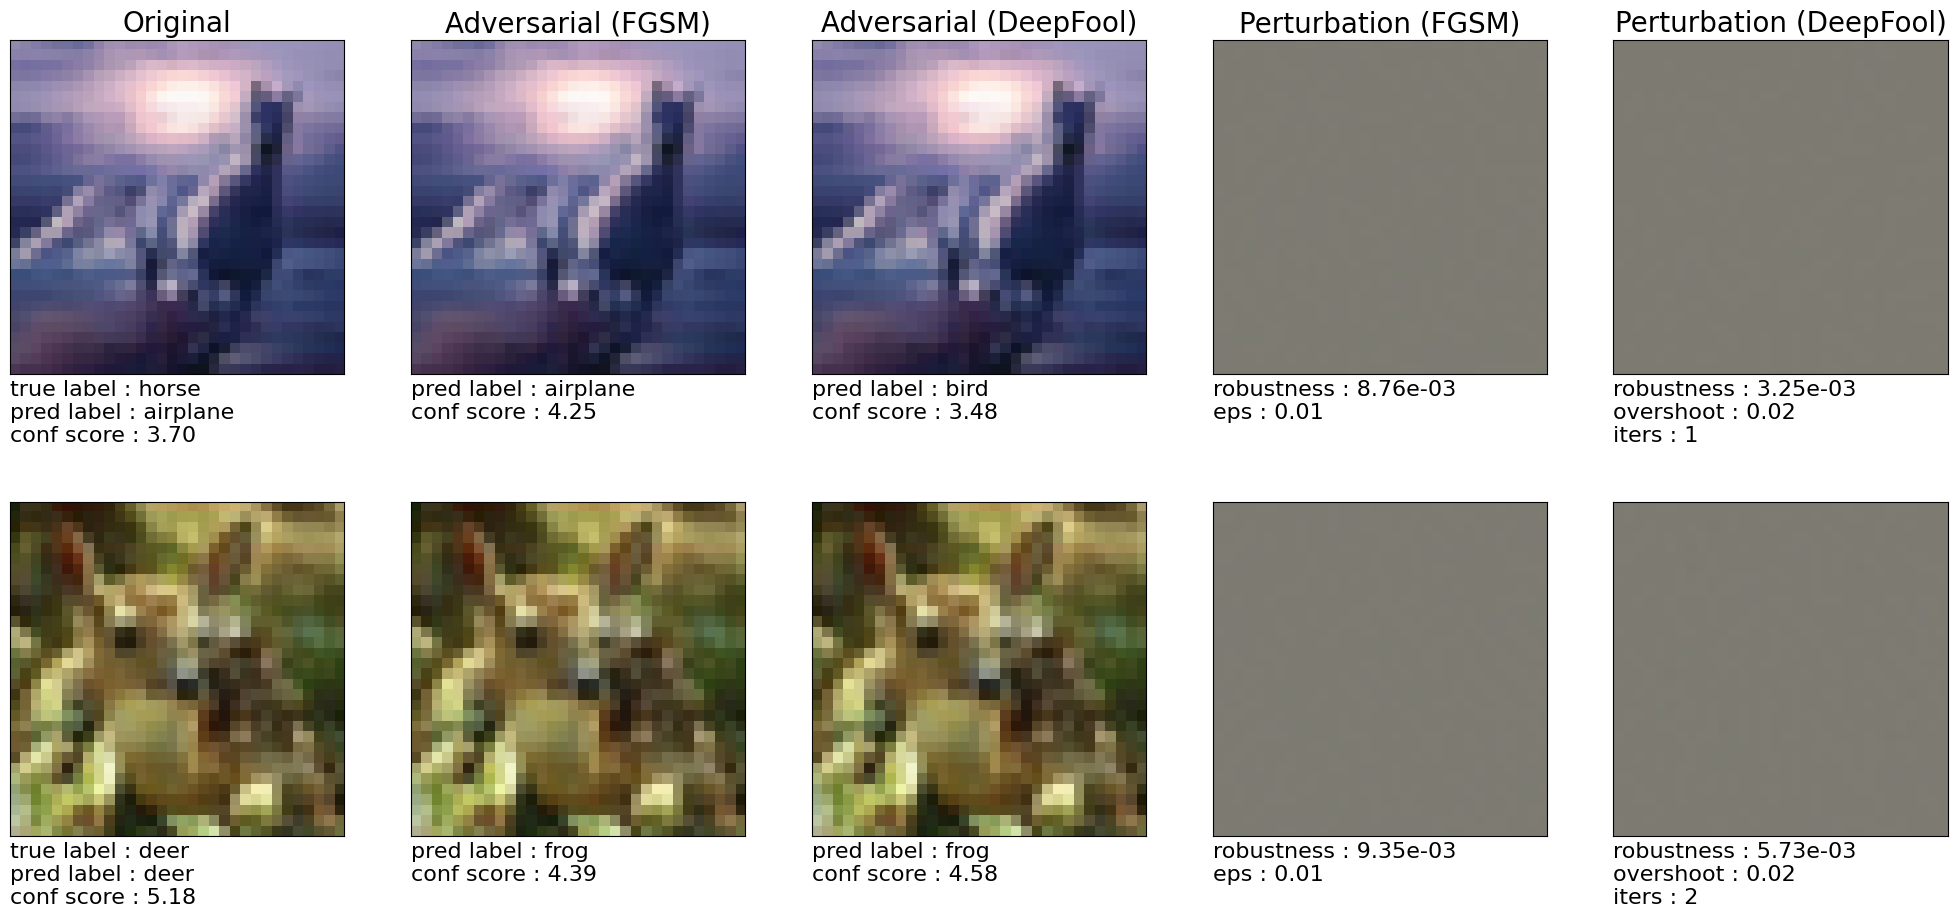

In [21]:
fgsm_eps = 0.01
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)
if device.type == 'cuda': torch.cuda.empty_cache()

#fgsm_eps = 0.01
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)
if device.type == 'cuda': torch.cuda.empty_cache()

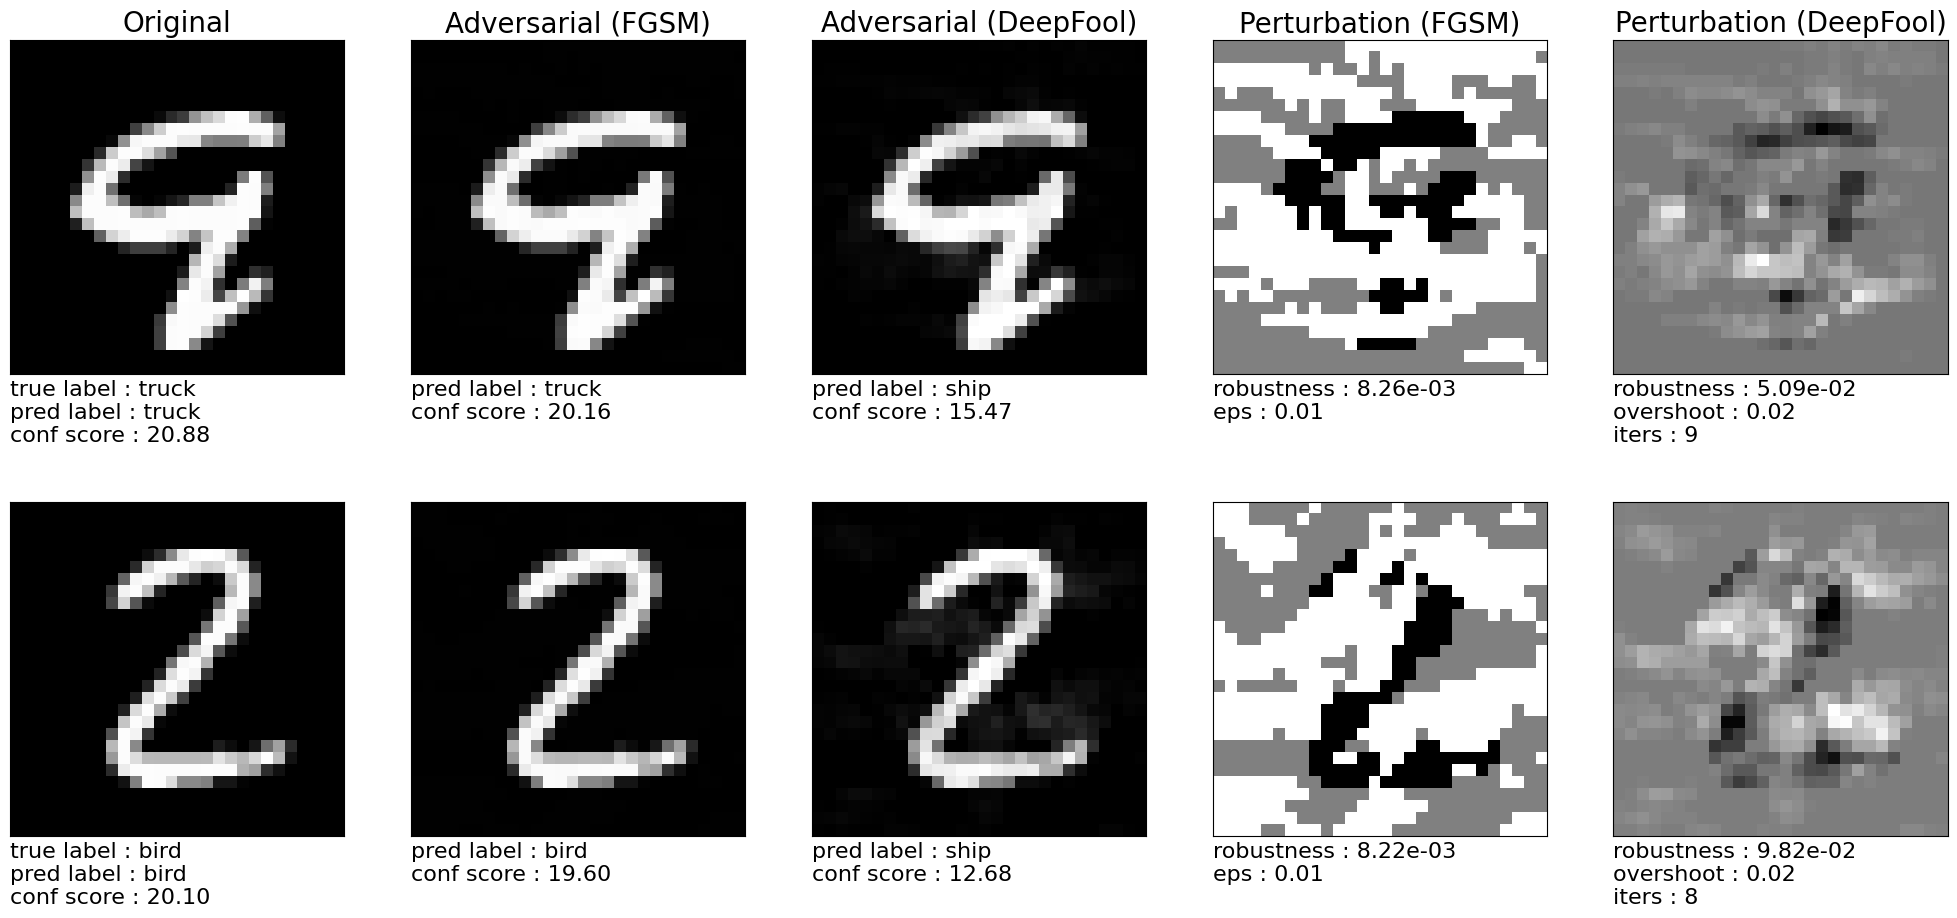

FGSM Test Error : 87.89%
FGSM Robustness : 4.58e-01
FGSM Time (All Images) : 0.29 s
FGSM Time (Per Image) : 28.86 us


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


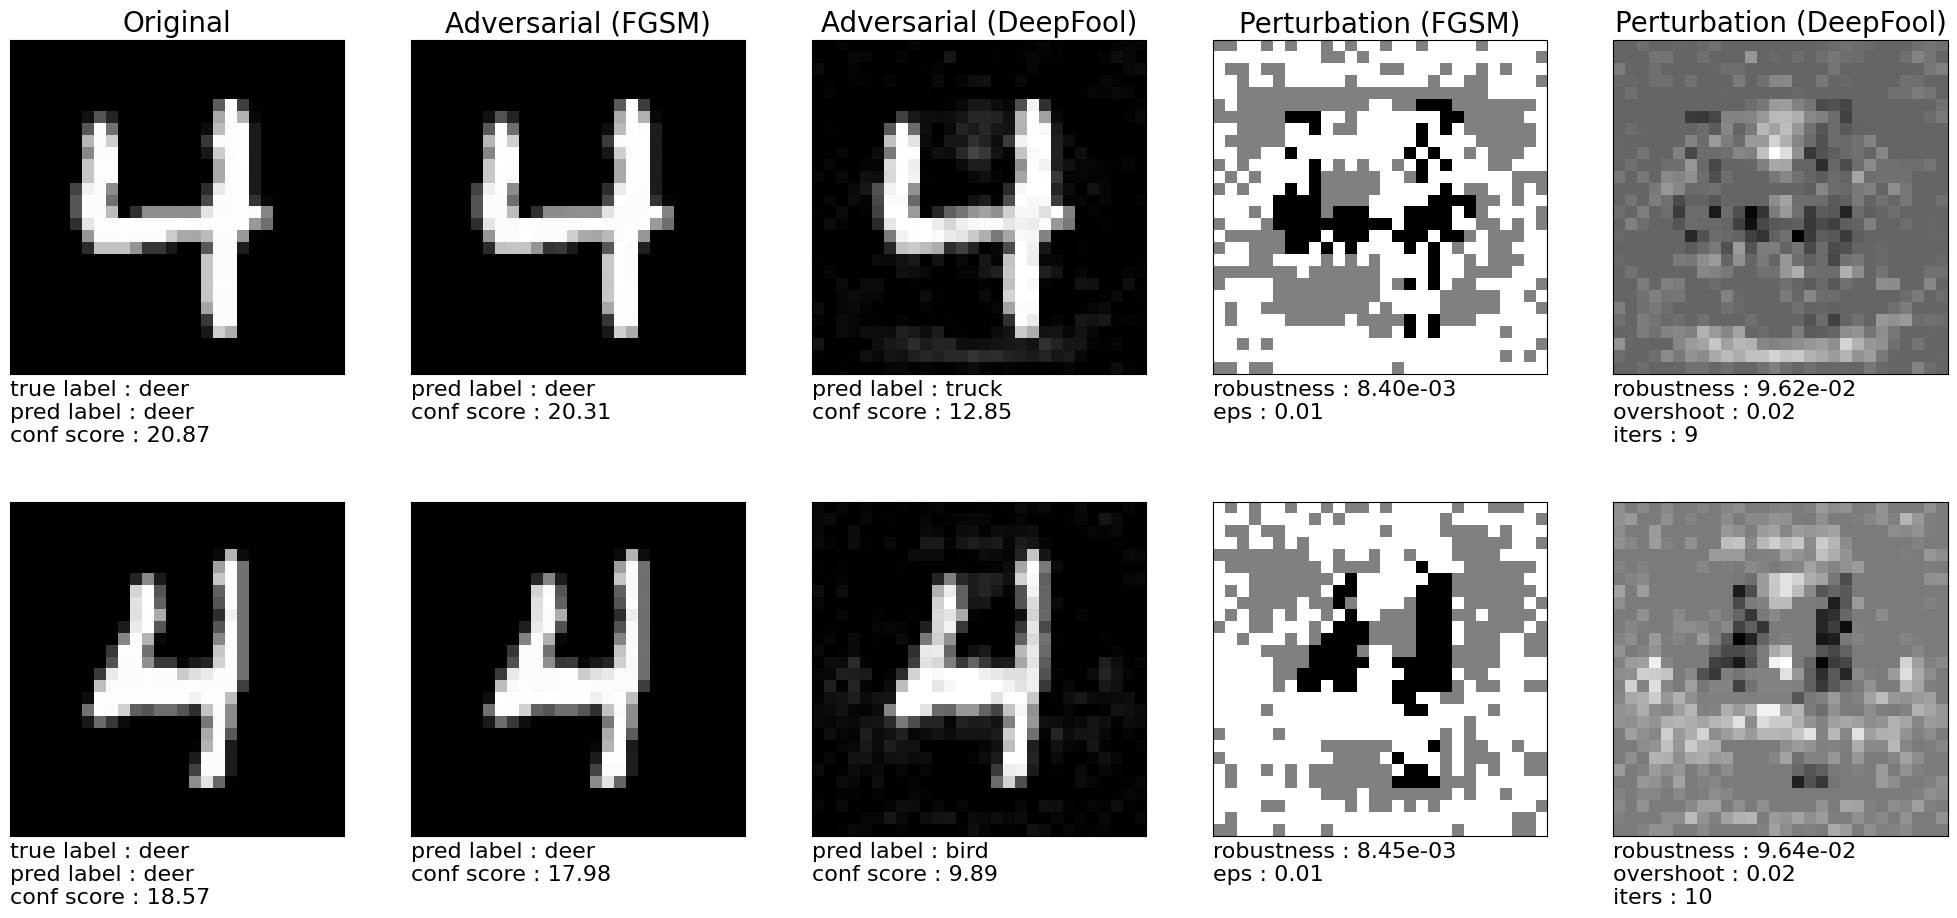

FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.15 s
FGSM Time (Per Image) : 14.99 us


In [22]:
fgsm_eps = 0.01
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)
evaluate_attack('mnist_lenet_fgsm.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
if device.type == 'cuda': torch.cuda.empty_cache()

fgsm_eps = 0.01
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)
evaluate_attack('mnist_fc_fgsm.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
if device.type == 'cuda': torch.cuda.empty_cache()

In [23]:
# NiN
fgsm_eps = 0.1
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=torch.device('cpu')))
evaluate_attack('cifar_lenet_nin.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
if device.type == 'cuda': torch.cuda.empty_cache()

print('')

#LeNet
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('cpu')))
evaluate_attack('cifar_lenet_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
if device.type == 'cuda': torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 77.44%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 1.28 s
FGSM Time (Per Image) : 127.82 us

FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us
